# Imports and files

In [6]:
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from PIL import Image
from utils import celltype_signatures

from sainsc import read_StereoSeq

In [7]:
data_path = Path("data") / "StereoSeq"
analysis_path = Path("embryo")

stereo_seq_file_embryo = data_path / "E16.5_E1S3_GEM_bin1.tsv.gz"
stereoseq_cell_h5ad = data_path / "E16.5_E1S3_cell_bin.h5ad"

In [4]:
analysis_path.mkdir(exist_ok=True, parents=True)

# Get signatures

In [ ]:
embryo_cells = ad.read_h5ad(stereoseq_cell_h5ad)

In [9]:
cmap = dict(
    zip(
        embryo_cells.obs["annotation"].cat.categories,
        embryo_cells.uns["annotation_colors"],
    )
)

In [13]:
embryo_cells.X = embryo_cells.layers["counts"]

In [14]:
sc.pp.filter_genes(embryo_cells, min_counts=100)

In [15]:
sc.pp.highly_variable_genes(embryo_cells, n_top_genes=2_000, flavor="seurat_v3")

In [16]:
sc.pp.normalize_total(embryo_cells, target_sum=1e4)

In [17]:
signatures = celltype_signatures(
    embryo_cells[:, embryo_cells.var["highly_variable"]], celltype_col="annotation"
)

signatures = signatures.reindex(sorted(signatures.columns), axis=1)

# Determine usable area

This is probably easier done while reading the file binned which is much faster

In [18]:
embryo = read_StereoSeq(stereo_seq_file_embryo, n_threads=16)

print(embryo)

LazyKDE (16 threads)
    genes: 28633
    shape: (44100, 26460)
    resolution: 500.0 nm / px


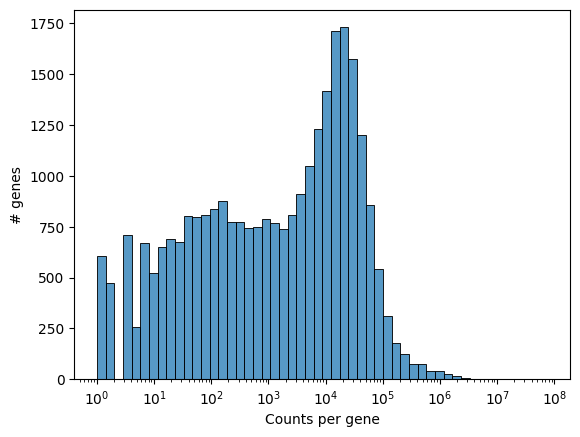

In [19]:
_ = embryo.plot_genecount_histogram()

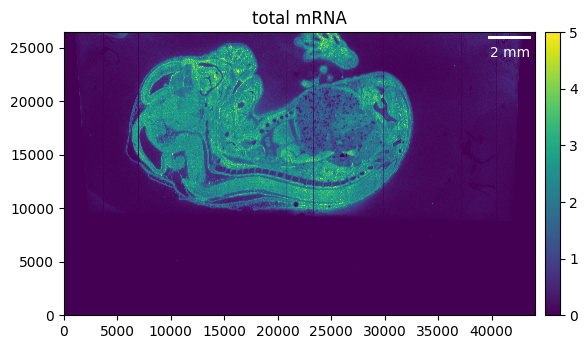

In [20]:
embryo.calculate_total_mRNA()

_ = embryo.plot_genecount(im_kwargs={"vmax": 5})

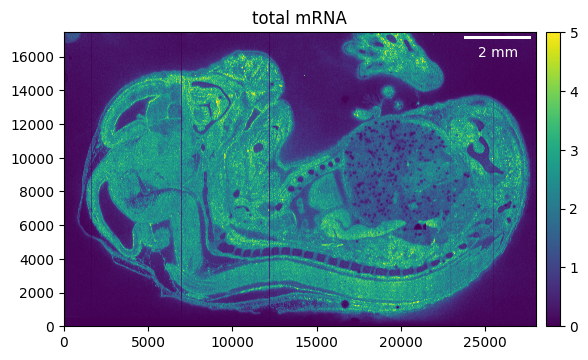

In [21]:
coords = ((5_000, 33_000), (9_000, None))

embryo.counts.crop(*coords)

embryo.calculate_total_mRNA()

_ = embryo.plot_genecount(im_kwargs={"vmax": 5})

We can export the count array and use it to manually draw a selection mask

In [22]:
u8 = np.uint8
Image.fromarray(
    np.clip(embryo.total_mRNA, np.iinfo(u8).min, np.iinfo(u8).max).astype(u8)
).save(analysis_path / "embryo_cropped.png")

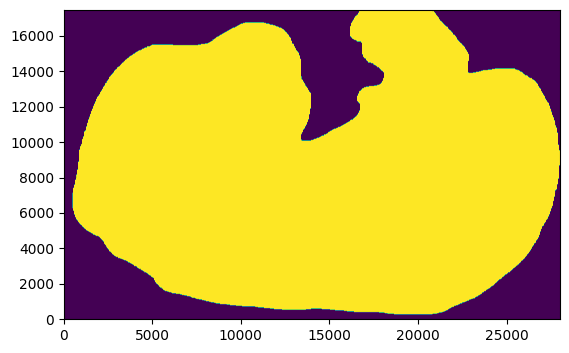

In [23]:
# avoid the DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

embryo_mask = np.array(Image.open(analysis_path / "embryo_selection.png")).astype(bool)

_ = plt.imshow(embryo_mask.T, origin="lower")

In [24]:
embryo.counts.filter_mask(embryo_mask)

del embryo_mask

In [25]:
# drop empty genes
ngenes_prior = len(embryo.genes)

embryo.counts.filter_genes_by_count(min=1)

print(f"Dropped {ngenes_prior-len(embryo.genes)} genes")

Dropped 75 genes


In [26]:
embryo.gaussian_kernel(8)

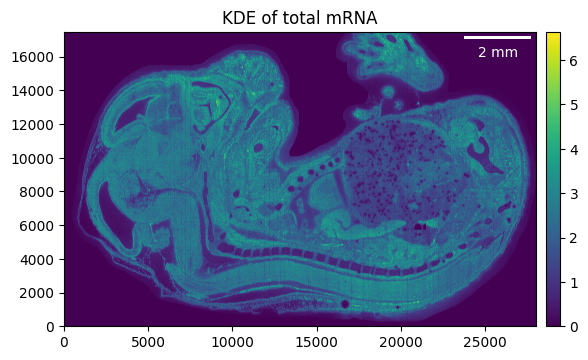

In [27]:
embryo.calculate_total_mRNA()
embryo.calculate_total_mRNA_KDE()

_ = embryo.plot_KDE()

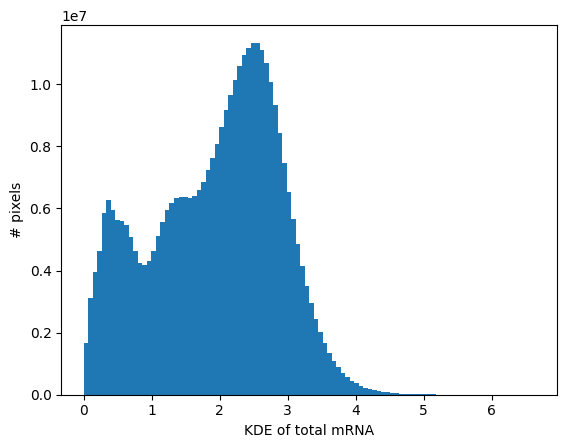

In [28]:
_ = embryo.plot_KDE_histogram(bins=100)

In [29]:
embryo.filter_background(1)

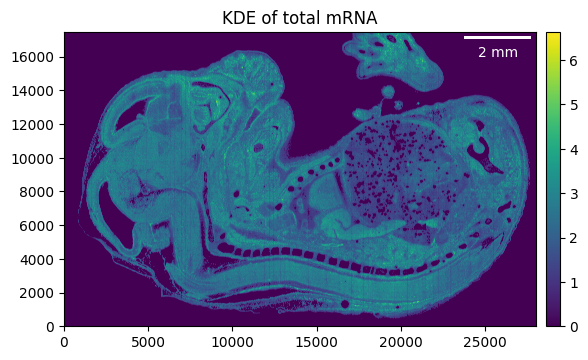

In [30]:
_ = embryo.plot_KDE(remove_background=True)

# Celltype map

In [31]:
embryo.assign_celltype(signatures)

print(embryo)

LazyKDE (16 threads)
    genes: 28558
    shape: (28000, 17460)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set
    celltypes: 25


In [ ]:
import pickle

with open(analysis_path / "embryo_supervised_wo_log.pickle", "wb") as file:
    pickle.dump(embryo, file)

In [33]:
kde_per_celltype = pd.DataFrame(
    {
        "kde": embryo.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            embryo.celltype_map.ravel(), categories=embryo.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.8)["kde"] / 3
).to_dict()

min_t = 0.9

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

embryo.filter_background(celltype_threshold)

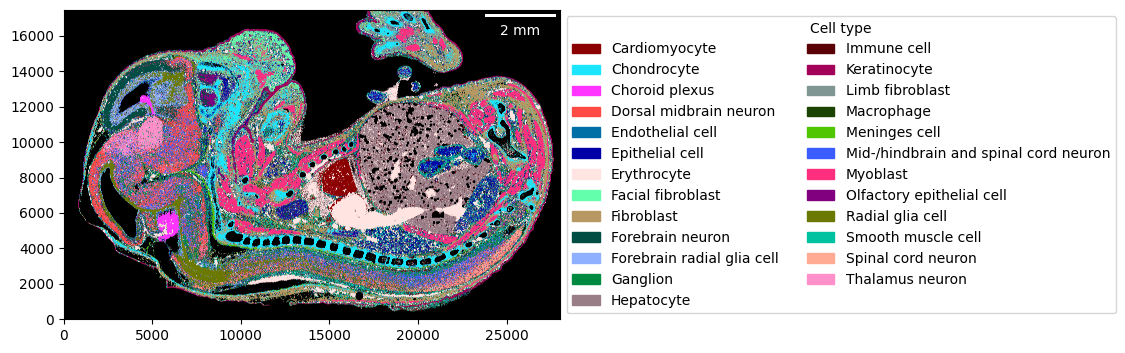

In [34]:
_ = embryo.plot_celltypemap(cmap=cmap)